# Import PycroMagnetics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import cupy as np
import time

path = os.getcwd()
path = os.path.dirname(path)
path = os.path.dirname(path)
sys.path.append(path)

import PycroMagnetics.pymag as ppm
import PycroMagnetics.mag_visualize as pmv
from PycroMagnetics import magmatlib as mml

import pandas as pd
import matplotlib.pyplot as plt

# Define Physical Space

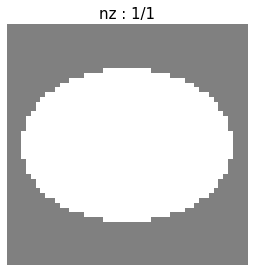

In [3]:
# Define space
m1 = ppm.Ferromagnet(Lx=50*10**-7, 
                     Ly=50*10**-7, 
                     Lz=1*10**-7, 
                     nx=50, 
                     ny=50, 
                     nz=1,
                     PBCx=False,
                     PBCy=False,
                     PBCz=False)

# Set geometry
m1.setCylindricalMask(center_x=25*10**-7, 
                      center_y=25*10**-7, 
                      center_z=0.5*10**-7, 
                      radius_x=22*10**-7, 
                      radius_y=16*10**-7, 
                      height=1*10**-7,
                      angle=0)

# Get material
mater1 = mml.Ni_PolyCrystal()
mater1.Ms = 1080

# Asign material to the object
m1.asign_material(mater1)

# Initialize magnetization state
m1.setUniformMagnetization(thetaM0=10, phiM0=80)

# Print asigned property
pmv.show_mask(m1, figsize=(5,5), fontsize=15)

# Warm-up Evolver

In [4]:
evol= ppm.Evolver(magnet=m1,
                  tstep=1e-13,
                  warm_up=True,
                  uniaxial_anisotropy_field=False,
                  exchang_field=True,
                  demag_field=True,
                  external_field=True,
                  DMI_field=False,
                  FLT_field=False,
                  DLT_field=False,
                  thermal_field=False,
                  random_state=None)

Start calculating demag factors
End calculating demag factors


In [5]:
# Set work name
name = 'test1'

# Set total calculation step number
total = 200000

# Set verbosity
verbose = 1

# Set Logger
mlogger = ppm.MagnetLogger(log_name=name)

# Set uniform external magnetic field
evol.setUniformExternalMagneticField(Hextx=0, Hexty=0, Hextz=0)

# Set start time
start = time.perf_counter()

# Start calculation loop
for i in range(total):

    # Calculate one step of evolution
    evol.evolve()
    
    # Set optimized time step
#     evol.cal_tstep(ideal_dm=0.0001)
    
    # Get end time
    end = time.perf_counter()
    
    # Get log
    if i%1000 == 0:
        total_mx = evol.magnet.mx.sum()
        total_my = evol.magnet.my.sum()
        total_mz = evol.magnet.mz.sum()
        mask_area = evol.magnet.mask.sum()
        mlogger(time=evol.time, dm=evol.dm, 
                mean_mx=total_mx/mask_area, 
                mean_my=total_my/mask_area, 
                mean_mz=total_mz/mask_area)
    
    # Save evolver
    if i%5000 == 0:
        ppm.save_Evolver(evol, name)
        
    if i%1000 == 0:   
        if verbose > 0:
            print('{}/{} time:{}'.format(i,total, end - start))
            print('current dm & tstep : {:e} & {:e}'.format(evol.dm, evol.tstep))
            print('  mean (mx, my, mz) : ({:e}, {:e}, {:e})'.format(total_mx/mask_area, 
                                                                    total_my/mask_area,
                                                                    total_mz/mask_area))

            
    # Set early stop
    if i==0:
        endure = 0
    if evol.dm<1.0*10**-15:
        endure += 1
    if evol.dm>=1.0*10**-15:
        endure = 0
    if endure >= 10:
        break

0/200000 time:0.021357099999988804
current dm & tstep : 3.871701e-04 & 1.000000e-13
  mean (mx, my, mz) : (3.021526e-02, 1.713528e-01, 9.847463e-01)
1000/200000 time:7.537028800000002
current dm & tstep : 9.924318e-04 & 1.000000e-13
  mean (mx, my, mz) : (1.462521e-01, 7.993994e-01, 5.811161e-01)
2000/200000 time:14.882729499999982
current dm & tstep : 2.225331e-04 & 1.000000e-13
  mean (mx, my, mz) : (1.860985e-01, 9.779068e-01, 9.187112e-02)
3000/200000 time:23.175617099999982
current dm & tstep : 3.149632e-05 & 1.000000e-13
  mean (mx, my, mz) : (1.942412e-01, 9.805148e-01, 1.195093e-02)
4000/200000 time:30.341478299999977
current dm & tstep : 1.108909e-05 & 1.000000e-13
  mean (mx, my, mz) : (2.019190e-01, 9.789857e-01, 1.548944e-03)
5000/200000 time:37.782381799999996
current dm & tstep : 1.000778e-05 & 1.000000e-13
  mean (mx, my, mz) : (2.098738e-01, 9.772880e-01, 2.007408e-04)
6000/200000 time:46.0052766
current dm & tstep : 1.009896e-05 & 1.000000e-13
  mean (mx, my, mz) : (2.

# Reuse Saved Evolver

In [7]:
name = 'test1'
evol = ppm.load_Evolver(name)
df = pd.read_csv('./log/'+name+'.csv')
df = df.astype('float64')
df.shape

(200, 5)

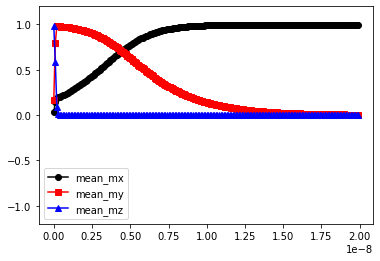

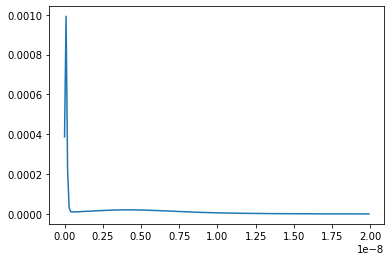

In [8]:
plt.plot(df['time (s)'], df['mean_mx'], '-ko', label='mean_mx')
plt.plot(df['time (s)'], df['mean_my'], '-rs', label='mean_my')
plt.plot(df['time (s)'], df['mean_mz'], '-b^', label='mean_mz')
plt.ylim(-1.2,1.2)
plt.legend()
plt.show()
plt.plot(df['time (s)'], df['dm'])
plt.show()

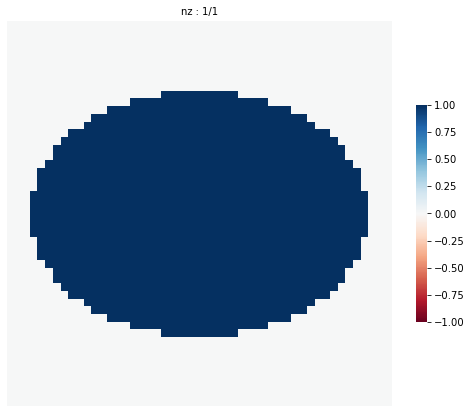

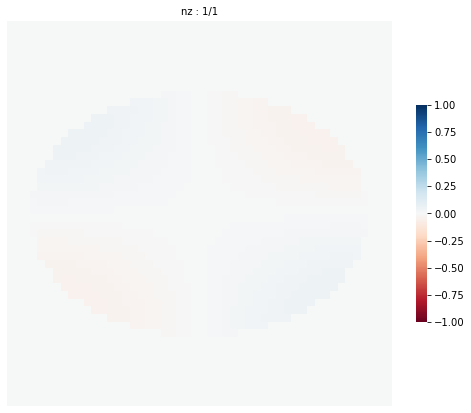

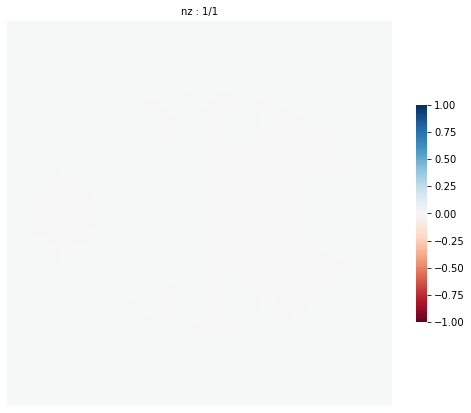

In [9]:
pmv.show_MagProperties(evol.magnet.mx, vmin=-1, vmax=1, fontsize=10, 
                       figsize=(10,10), shrink=0.4)
pmv.show_MagProperties(evol.magnet.my, vmin=-1, vmax=1, fontsize=10, 
                       figsize=(10,10), shrink=0.4)
pmv.show_MagProperties(evol.magnet.mz, vmin=-1, vmax=1, fontsize=10, 
                       figsize=(10,10), shrink=0.4)

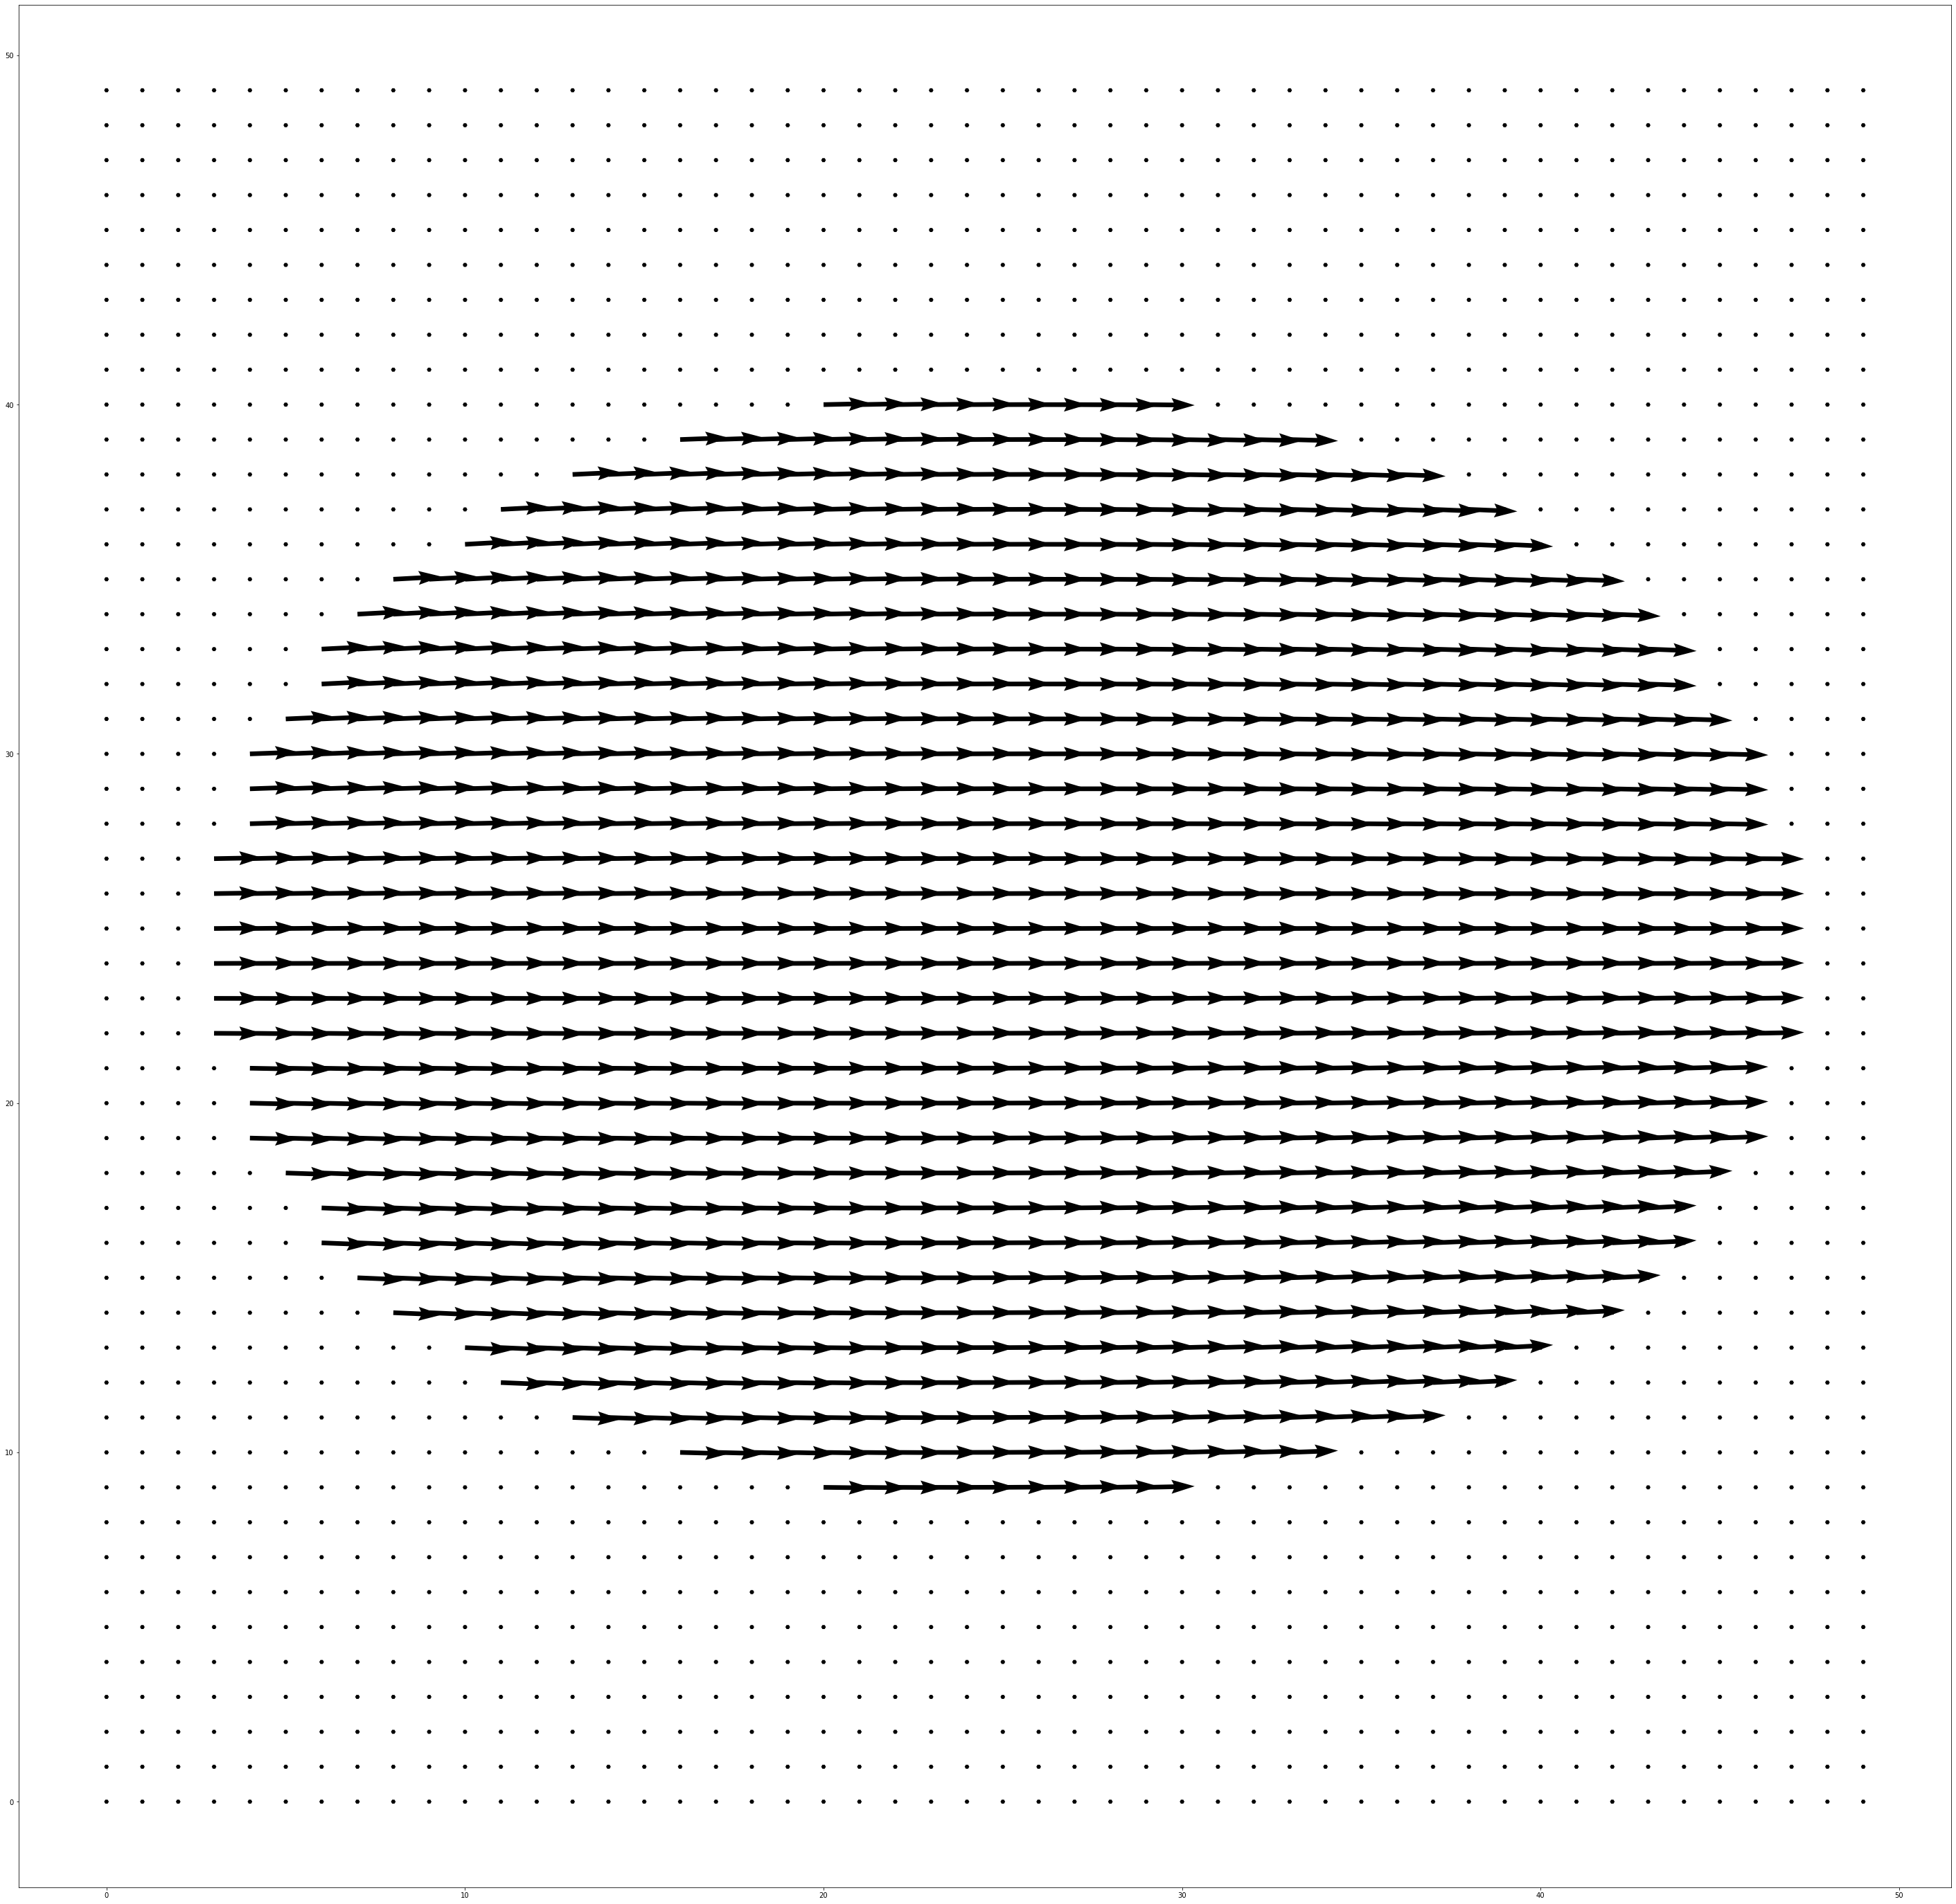

In [10]:
pmv.show_MagProperties_arrow(arrow_x=evol.magnet.mx[0], 
                             arrow_y=evol.magnet.my[0])